In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [16]:
from utils.preprocess import Dataset_for_transformer, preprocess_data, Dataset_for_finetune, preprocess_for_finetune
from utils.Encoder_model import make_Encoder_model
from utils.train_eval_utils import  plot_results, train_eval
from utils.loss_mask_utils import create_mask, cross_entropy_for_finetune

In [8]:
file_path_train = r'/home/aletovv/Learning-To-Rank/Transformer/datasets/datas_full_10k_1.pkl'
file_path_test = r'/home/aletovv/Learning-To-Rank/Transformer/datasets/datas_full_10k_1.pkl'

train_data = preprocess_data(file_path_train,num_docs=850, which=0, is_shuffle=True, device = 'cuda')
val_data = preprocess_data(file_path_test, num_docs=908, which=-1, is_shuffle=True, device = 'cuda')

preprocess is done
preprocess is done


In [9]:
def load_model(file, params):
    model = make_Encoder_model(**params)
    state_dict = torch.load(file)
    model.load_state_dict(state_dict)
    model.to('cuda')
    return model

In [19]:
batch_size_train = 1
batch_size_test = 128

train_dataset = Dataset_for_transformer(train_data)
val_dataset = Dataset_for_transformer(val_data)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_test, shuffle=True)

In [20]:
input_dim = train_dataset[0][0].shape[-1]
output_dim = 5
device = 'cuda'

model_parameters = {'d_model' : 512,
                    'n_heads' : 2,
                    'n_layers' : 2,
                    'ffn_hidden' : 512,
                    'input_dim' : input_dim,
                    'dropout_rate' : 0.15,
                    'device' : device,
                    'output_dim' : output_dim}

In [21]:
model = load_model(file = r'/home/aletovv/Learning-To-Rank/Transformer/best model with best metric.pth', params=model_parameters)

new_data = preprocess_for_finetune(train_loader, model, p = 0.75)

/tmp/ipykernel_2598243/763263313.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file)


In [22]:
train_dataset_fine = Dataset_for_finetune(new_data)
train_loader = DataLoader(train_dataset_fine, batch_size=128, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001)


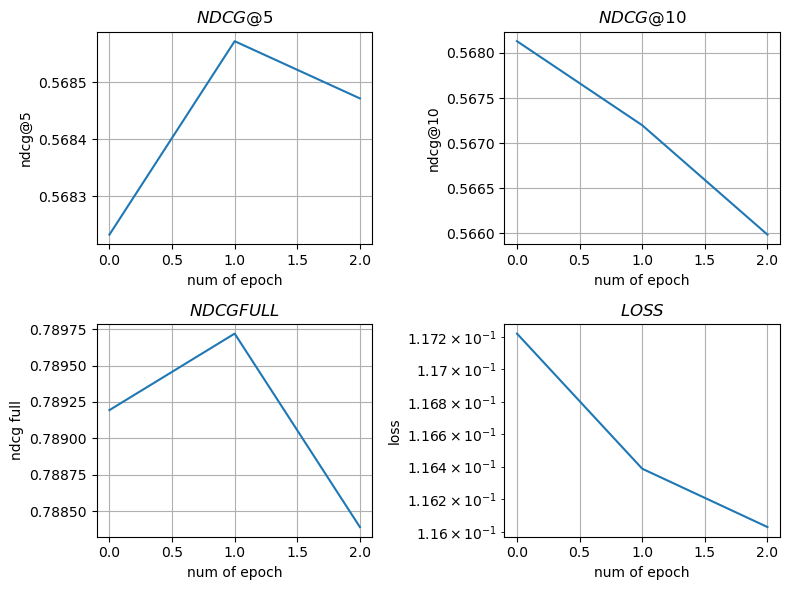

Epoch [3/3], Loss: 0.1160
NDCG@5 0.5685 || NDCG@10 0.5660 || Avg NDCG: 0.7884 


([0.11722161668412229, 0.1163870319724083, 0.11602866395990899],
 {'ndcg@5': [0.5682327677545586, 0.5685718056833641, 0.568471559740193],
  'ndcg@10': [0.5681290313305826, 0.5671982105355625, 0.5659866400132281],
  'ndcg full': [0.7891943586040776, 0.7897191976050468, 0.7883920881617641]})

In [23]:
train_eval(train_loader=train_loader, model=model,
           optimizer=optimizer, loss_fn=cross_entropy_for_finetune,
           num_epochs=3, create_mask=create_mask,val_loader=val_loader)